## Single Task Learning prediction for kinases with data from ChEMBL
This notebook evaluates and compares the performance of three regressors, Random Forests, Neural Networks, and Lasso Regression, all implemented by Scikit-learn for predicting bioactivity values. We are using pIC50 values on a dataset with 110 targets. As we are not interested for optimisation at this point, we run just a quick parameter selection through a 4-fold cross-validation.

## 0. Prerequisites

In [13]:
import numpy as np
import pandas as pd
import keras
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
# from sklearn.decomposition import TruncatedSVD as tSVD

import  matplotlib.pyplot as plt
random_seed = 2019
np.random.seed(random_seed)
nfolds=4
njobs =3
# RESCALE_FACTOR = 10.0 # 0-10000 -> 0-1000 # no need for that, we use -logIC50 instead.

### Load data file from disk 

In [14]:
if os.path.isfile("Interactions_Trainset.tab"):
    # train-valid exist so, load them
    print("Loading train/valid sets...")
    Interactions_train = []    
    with open("Interactions_Trainset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])
    
    Interactions_valid = []        
    with open("Interactions_Validset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])

Interactions = [x for x in Interactions_train]
Interactions.extend(Interactions_valid)
# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints_FCFP.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

values = [x[2] for x in Interactions]
print("New data: {0} | {1}".format(np.mean(values), np.std(values)))

Loading train/valid sets...
There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
New data: -3.729252376472369e-08 | 1.00000002341196


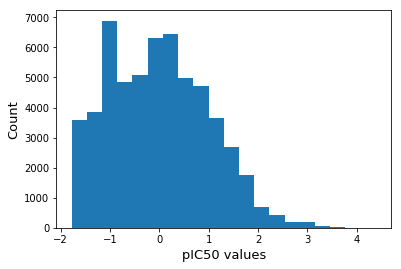

In [15]:
plt.hist(values, bins=20)
plt.xlabel('pIC50 values', fontsize=13)
plt.ylabel('Count',fontsize=13)
# plt.savefig("TrueDistr.png")
plt.show()

## 1. Random Forests

In [16]:
Target_info = {} # this is a "global" variable

RF_all = dict()
Scores_RF_train=[]
count=0
param_grid={'n_estimators':[10,25,50,100,150], 'max_depth':[3,4,5,7,10,15,20], 'max_features':['sqrt','auto']}
for target in Targets:
    Target_info[target] = {}
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        Target_info[target]['train_size']=len(Y_train) # add info
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        # here comes the long step
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        RFR = RandomForestRegressor( n_estimators= cvr.best_params_['n_estimators'],max_features=cvr.best_params_['max_features'], max_depth=cvr.best_params_['max_depth'], random_state=2019)
        RFR.fit(X_train,Y_train)
        RF_all[target] = RFR
        Scores_RF_train.append( RFR.score( X_train,  Y_train))
        Target_info[target]['RF_train_r2'] = Scores_RF_train[-1] # add info
#         print(Scores_RFR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_RF_train))
    count+=1
    
print("Mean score for RF during training = %f" % np.mean(Scores_RF_train) )

More than 0 targets are processed
Mean score so far: 0.917265
More than 25 targets are processed
Mean score so far: 0.893678
More than 50 targets are processed
Mean score so far: 0.893908
More than 75 targets are processed
Mean score so far: 0.895612
More than 100 targets are processed
Mean score so far: 0.891373
Mean score for RF during training = 0.890407


## 2. Neural Networks

In [17]:
NN_all = dict()
Scores_NN_train=[]
param_grid={'hidden_layer_sizes':[(50),(50,20),(50,100),(50,20,10)] }
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(MLPRegressor(activation='logistic', solver='lbfgs', random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        MLPR = MLPRegressor( hidden_layer_sizes = cvr.best_params_['hidden_layer_sizes'], activation='logistic', solver='lbfgs', random_state=2019)
        MLPR.fit(X_train,Y_train)
        NN_all[target] = MLPR
        Scores_NN_train.append( MLPR.score( X_train,  Y_train))
        Target_info[target]['NN_train_r2'] = Scores_NN_train[-1] # add info
#         print(Scores_MLPR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_NN_train))
    count+=1
    
print("Mean score for NN during training = %f" % np.mean(Scores_NN_train))

More than 0 targets are processed
Mean score so far: 0.999790
More than 25 targets are processed
Mean score so far: 0.987354
More than 50 targets are processed
Mean score so far: 0.984453
More than 75 targets are processed
Mean score so far: 0.982517
More than 100 targets are processed
Mean score so far: 0.973876
Mean score for NN during training = 0.968334


## 3. Lasso Regression

In [18]:
from sklearn.linear_model import Lasso

LR_all = dict()
Scores_LR_train=[]
param_grid={'alpha':[1, 0.5, 0.1, 0.01]}
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    # cross validation
    cvr = GridSearchCV(Lasso(random_state=2019, max_iter=5000), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
    cvr.fit(X_train, Y_train)
    # select best parametrisation
    LR = Lasso( alpha= cvr.best_params_['alpha'], max_iter=5000, random_state=2019)
    LR.fit(X_train,Y_train)
    Scores_LR_train.append( LR.score( X_train,  Y_train))
    Target_info[target]['LR_train_r2'] = Scores_LR_train[-1] # add info
    LR_all[target] = LR
#     print(Scores_LR_train[-1])
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_LR_train))
    count+=1 

print("Mean score for LR during training = %f" % np.mean(Scores_LR_train) )

More than 0 targets are processed
Mean score so far: 0.914118
More than 25 targets are processed
Mean score so far: 0.799120
More than 50 targets are processed
Mean score so far: 0.757541
More than 75 targets are processed
Mean score so far: 0.718546
More than 100 targets are processed
Mean score so far: 0.672033
Mean score for LR during training = 0.659301


## 4. Personalised NN with Keras

In [19]:
myNN_all = dict()
Scores_myNN_train=[]
param_grid={'lamda':[0.2, 0.1, 0.01, 0.001]}
count=0

def mymodel(lamda, init=-4.5):
    model = Sequential()

    model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=2048))
    model.add(Dense(units=20,  activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=100 ))
    myinit = keras.initializers.Constant(value=init)
    model.add(Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.001)))
    
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.001))
    return model

for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
        
    if len(Y_train)>40:
        X_train = np.array( X_train )

        myNN = KerasRegressor(build_fn=mymodel, init=-4.5, epochs=250, batch_size=20, verbose=0)
        
        # fit model to data:
        cvr = GridSearchCV(myNN, param_grid=param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        
        myNN = KerasRegressor(build_fn=mymodel, init=-4.5, lamda=cvr.best_params_['lamda'], epochs=250, batch_size=20, verbose=0)
        myNN.fit(X_train,Y_train)
        Y_NN = myNN.predict(X_train)
        # get scores and details:
        Scores_myNN_train.append( r2_score(Y_train, Y_NN) )
        Target_info[target]['my_train_r2'] = Scores_myNN_train[-1] # add info
#         print("R2 score for {0} with {1} items = {2:.3f}".format(target, len(Y_train), Scores_myNN_train[-1]))
        myNN_all[target] = myNN # save model for validation

    else:
        print("Not enough data for %s" % target)
    if count%20==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_myNN_train))
    count+=1
    
print("Mean score for myNN during training = %f" % np.mean(Scores_myNN_train) )







More than 0 targets are processed
Mean score so far: 0.675119
More than 20 targets are processed
Mean score so far: 0.769029
More than 40 targets are processed
Mean score so far: 0.755406
More than 60 targets are processed
Mean score so far: 0.799804
More than 80 targets are processed
Mean score so far: 0.825412
More than 100 targets are processed
Mean score so far: 0.842835
Mean score for myNN during training = 0.850978


## 5. Evaluation

In [20]:
Pred_NN = []; Pred_RF  = []; Pred_LR = []; Pred_my=[];
True_vals = []
Pred_pertarget = dict() # contains lists with tuples: (true, pred_RF, pred_NN)

with open("SingleTL_FCFP_results.txt",'w') as f:
    # this file contains all the important stuff for the comparison
    f.write("Target\tCompound\tTrue\tRFR\tMLPR\tLR\tKeras\n")
    for point in Interactions_valid:
        # point = [ target, compound, pIC50 ]
        True_vals.append( float(point[2]) )
        x_test = np.array( Fingerprints[point[1]] ).reshape(1,-1) # prepare for prediction

        model = RF_all[point[0]]
        Pred_RF.append( model.predict( x_test ) )

        model = NN_all[point[0]]
        Pred_NN.append( model.predict( x_test ) )

        model = LR_all[point[0]]
        Pred_LR.append( model.predict( x_test ) )
        
        model = myNN_all[point[0]]
        Pred_my.append( model.predict( x_test ) )

        f.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(point[0], point[1], point[2], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]))

        if point[0] in Pred_pertarget:
            Pred_pertarget[point[0]].append( (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0])  )
        else:
            # first time for this protein
            Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]) ]
        
print("Performance for RF = %f" % r2_score( True_vals, Pred_RF ))
print("Performance for NN = %f" % r2_score( True_vals, Pred_NN ))
print("Performance for LR = %f" % r2_score( True_vals, Pred_LR ))
print("Performance for Keras = %f" % r2_score( True_vals, Pred_my ))

Performance for RF = 0.647218
Performance for NN = 0.576720
Performance for LR = 0.544289
Performance for Keras = 0.596589


In [21]:
Scores_RF_valid_pertarget = []
Scores_NN_valid_pertarget = []
Scores_LR_valid_pertarget = []
Scores_my_valid_pertarget = []

for target in Pred_pertarget:
    true=[]
    pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my =[] # temp variables
    # aggregate predictions
    for point in Pred_pertarget[target]:
        true.append( point[0] )
        pred_RF.append( point[1] )
        pred_NN.append( point[2] )
        pred_LR.append( point[3] )
        pred_my.append( point[4] )
    Target_info[target]['valid_size']=len(true) # add info
    
    # calculate performance for each method
    r2 = r2_score(true, pred_RF)
    Target_info[target]['RF_valid_r2'] = r2 # add info
    Scores_RF_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_NN)
    Target_info[target]['NN_valid_r2'] = r2 # add info
    Scores_NN_valid_pertarget.append( r2 )

    r2 = r2_score(true, pred_LR)
    Target_info[target]['LR_valid_r2'] = r2 # add info
    Scores_LR_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_my)
    Target_info[target]['my_valid_r2'] = r2 # add info
    Scores_my_valid_pertarget.append( r2 )

    print("R2 score for {0}, RF | NN | LR | Keras = {1:.2f} | {2:.2f} | {3:.2f} | {4:.3f}".format(target, Scores_RF_valid_pertarget[-1], Scores_NN_valid_pertarget[-1], Scores_LR_valid_pertarget[-1], Scores_my_valid_pertarget[-1]))

R2 score for CHEMBL260, RF | NN | LR | Keras = 0.66 | 0.30 | 0.53 | 0.508
R2 score for CHEMBL4722, RF | NN | LR | Keras = 0.68 | 0.58 | 0.53 | 0.614
R2 score for CHEMBL2695, RF | NN | LR | Keras = 0.58 | 0.60 | 0.60 | 0.600
R2 score for CHEMBL3038477, RF | NN | LR | Keras = 0.43 | 0.20 | 0.31 | 0.293
R2 score for CHEMBL2996, RF | NN | LR | Keras = 0.45 | 0.32 | 0.39 | 0.464
R2 score for CHEMBL2148, RF | NN | LR | Keras = 0.74 | 0.72 | 0.63 | 0.727
R2 score for CHEMBL2147, RF | NN | LR | Keras = 0.68 | 0.66 | 0.56 | 0.662
R2 score for CHEMBL5147, RF | NN | LR | Keras = 0.40 | 0.35 | 0.35 | 0.366
R2 score for CHEMBL308, RF | NN | LR | Keras = 0.51 | 0.43 | 0.34 | 0.495
R2 score for CHEMBL3234, RF | NN | LR | Keras = 0.57 | 0.53 | 0.42 | 0.611
R2 score for CHEMBL4523, RF | NN | LR | Keras = 0.64 | 0.60 | 0.47 | 0.606
R2 score for CHEMBL2358, RF | NN | LR | Keras = 0.32 | 0.15 | 0.19 | 0.278
R2 score for CHEMBL1936, RF | NN | LR | Keras = 0.44 | 0.27 | 0.24 | 0.280
R2 score for CHEMBL3629,

In [22]:
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_valid_pertarget), np.std(Scores_RF_valid_pertarget) )) 
print("Mean per target R2-score for NN = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_NN_valid_pertarget), np.std(Scores_NN_valid_pertarget) ))
print("Mean per target R2-score for LR = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_LR_valid_pertarget), np.std(Scores_LR_valid_pertarget) ))
print("Mean per target R2-score for my = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_my_valid_pertarget), np.std(Scores_my_valid_pertarget) ))

Mean per target R2-score for RF = 0.4887 and std = 0.2010
Mean per target R2-score for NN = 0.3548 and std = 0.3089
Mean per target R2-score for LR = 0.4254 and std = 0.1740
Mean per target R2-score for my = 0.4211 and std = 0.1884


## 6. Analysis and Plotting

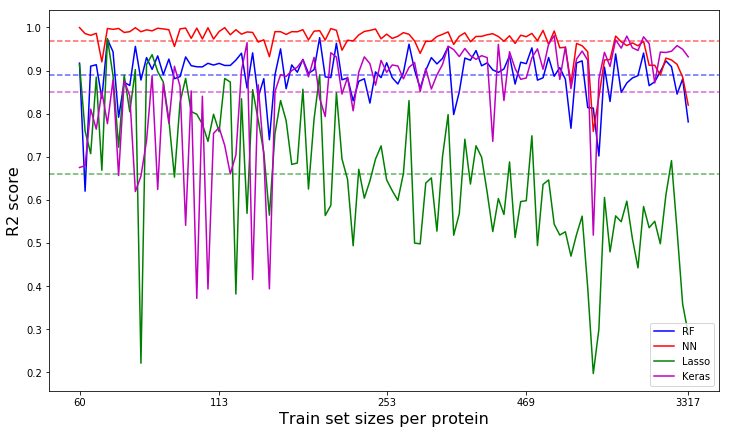

In [23]:
plt.figure(figsize=(12,7))

Y = [Target_info[x]['RF_train_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_train_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_train_r2'] for x in Targets]
plt.plot(Y,'g', label='Lasso')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_train_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

Sizes = [Target_info[x]['train_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Train set sizes per protein',fontsize=16)
plt.ylabel('R2 score',fontsize=16)
# plt.xticks( x, rotation='vertical')
plt.legend(loc=4)
# plt.title("Training Performance")
plt.savefig("Train-all.png")
plt.show()

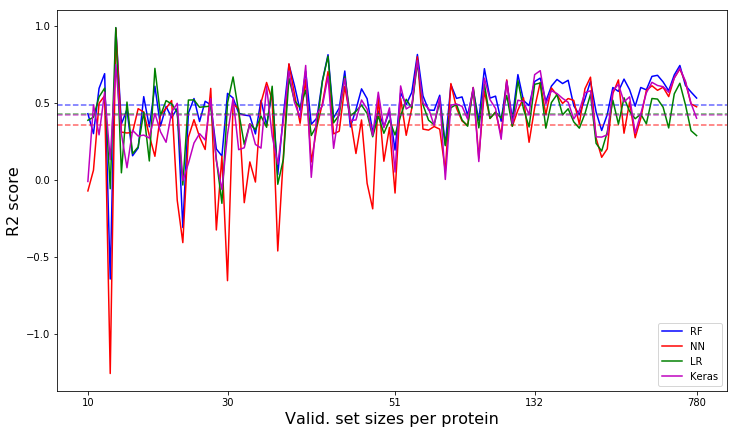

In [86]:
plt.figure(figsize=(12,7))

Y = [Target_info[x]['RF_valid_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_valid_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_valid_r2'] for x in Targets]
plt.plot(Y,'g', label='LR')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_valid_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)
plt.legend(loc=4)

Sizes = [Target_info[x]['valid_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Valid. set sizes per protein',fontsize=16)
plt.ylabel('R2 score',fontsize=16)
# plt.title("Validation Performance")
plt.savefig("Valid-all.png")
plt.show()

### Just a scatterplot for all three approaches

In [ ]:
target = Targets[70]
true=[]
pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my=[];
# aggregate predictions
for tuples in Pred_pertarget[target]:
    true.append( tuples[0] )
    pred_RF.append( tuples[1] )
    pred_NN.append( tuples[2] )
    pred_LR.append( tuples[3] )
    pred_my.append( tuples[4] )
    
plt.figure()
plt.plot(true, pred_RF,'x',label='RF')
plt.plot(true, pred_NN,'r.',label='NN')
plt.plot(true, pred_LR,'g.',label='LR')
plt.plot(true, pred_my,'m.',label='Keras')
plt.plot([-8.5,0],[-8.5,0])

plt.legend(loc=4)
plt.show()

### How to get the dominant parametrisations

In [28]:
from scipy.stats import mode
temp1 = []; temp2=[]; temp3=[]; temp4=[]; temp5=[];
for model in LR_all:
    temp1.append( LR_all[model].get_params()['alpha'] )
    temp2.append( RF_all[model].get_params()['n_estimators'] )
    temp3.append( RF_all[model].get_params()['max_depth'] )
    temp4.append( NN_all[model].get_params()['hidden_layer_sizes'])
    temp5.append( myNN_all[model].get_params()['lamda'] )
print('LR - best alpha = {0} with {1}.'.format( mode(temp1)[0], mode(temp1)[1][0]) )
print('RF - best n-estimat = {0} with {1}.'.format( mode(temp2)[0], mode(temp2)[1][0]) )
print('RF - best max-depth = {0} with {1}.'.format( mode(temp3)[0], mode(temp3)[1][0]) )
print('Keras - best lamda = {0} with {1}'.format( mode(temp5)[0], mode(temp5)[1][0]) )
temp_dict={}
for x in temp4:
    if str(x) in temp_dict:
        temp_dict[ str(x) ]+=1
    else:
        temp_dict[ str(x) ] = 1
print("NN - hidden layers:")
print( temp_dict)
# for model in NN_all:
#     print( NN_all[model].get_params()['hidden_layer_sizes'])

LR - best alpha = [0.01] with 107.
RF - best n-estimat = [150] with 57.
RF - best max-depth = [20] with 68.
Keras - best lamda = [0.001] with 45
NN - hidden layers:
{'50': 9, '(50, 20, 10)': 44, '(50, 20)': 25, '(50, 100)': 32}


### Try to trace-back the bits of high-impact

In [82]:
# Coefficients by Lasso
Coef_LR = np.zeros(2048)
for model in LR_all:
    Coef_LR += LR_all[model].coef_
Coef_LR = Coef_LR/110  

indices_LR = []
ind = np.argsort(Coef_LR)
[indices_LR.append(x) for x in ind[:10] ]
[indices_LR.append(x) for x in ind[-10:] ]
print(indices_LR)

# Coefficients by RF
Coef_RF = np.zeros(2048)
for target in Targets:
    Coef_RF += RF_all[target].feature_importances_
Coef_RF = Coef_RF/110  

indices_RF = []
ind = np.argsort(Coef_RF)
[indices_RF.append(x) for x in ind[-20:] ]
print(indices_RF)
print("Common features:",'\t',[x for x in indices_LR if x in indices_RF])
# plt.plot( range(2048), Coef, '.')
# plt.plot( indices, Coef[indices], 'rx')
# # plt.plot( Coef[indices], 'o')
# plt.xlabel("Fingerprint Bit location",fontsize=13)
# plt.ylabel("Average Coefficient",fontsize=13)
# # plt.title("Most important FP bits")
# plt.savefig("Lasso-bits_FCFP.png")
# plt.show()

[1607, 598, 1057, 232, 886, 418, 590, 1485, 1390, 1395, 2041, 553, 2039, 1826, 1394, 1639, 1925, 715, 901, 1185]
[1173, 1379, 397, 9, 1863, 824, 1672, 857, 806, 1085, 835, 1009, 1889, 2039, 476, 792, 1556, 1339, 1915, 598]
Common features: 	 [598, 2039]


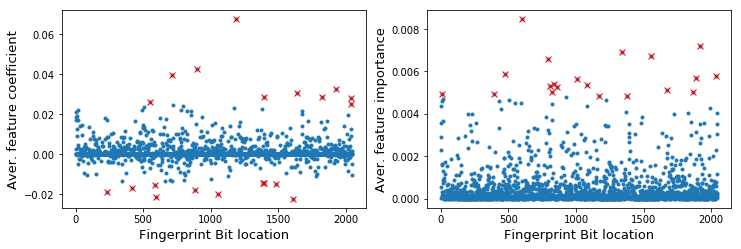

In [83]:
# fig = plt.subplots(1,2, figsize=(12,4))  # 1 row, 2 columns
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
plt.plot( range(2048), Coef, '.')
plt.plot( indices, Coef[indices], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature coefficient",fontsize=13)

ax1 = fig.add_subplot(222)
plt.plot( range(2048), Coef_RF, '.')
plt.plot( indices_RF, Coef_RF[indices_RF], 'rx')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Aver. feature importance",fontsize=13)
# plt.savefig("Lasso-bits_FCFP.png")
plt.show()

In [26]:
print("RMSE for RF = %f" % np.sqrt( MSE(True_vals, Pred_NN) ))
print("RMSE for NN = %f" % np.sqrt( MSE(True_vals, Pred_LR) ))
print("RMSE for LR = %f" % np.sqrt( MSE(True_vals, Pred_RF) ))
print("RMSE for Keras = %f" % np.sqrt( MSE(True_vals, Pred_my) ))

RMSE for RF = 0.646695
RMSE for NN = 0.671012
RMSE for LR = 0.590390
RMSE for Keras = 0.631334


### Some comparisons of distributions

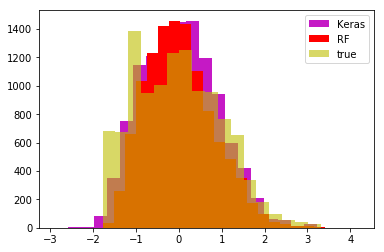

In [27]:
plt.hist([t[0] for t in Pred_my],bins=20,color='m',alpha=0.9, label="Keras")

plt.hist([t[0] for t in Pred_RF],bins=20,color='r',label="RF")

plt.hist([t for t in True_vals],bins=20,color='y',alpha=0.6, label='true')
plt.legend(loc=1)
plt.show()

## 7. Save models

In [ ]:
import pickle
wheretosave='TrainedModels/'
!(mkdir TrainedModels ) 

for target in Targets:
#     for clf in ['RF','LR','NN']:
    model = RF_all[target]
    filename = wheretosave+'RF_'+target+'_'+'pIC50model.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    model = LR_all[target]
    filename = wheretosave+'LR_'+target+'_'+'pIC50model.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    model = NN_all[target]
    filename = wheretosave+'NN_'+target+'_'+'pIC50model.sav'
    pickle.dump(model, open(filename, 'wb'))

# !(mv TrainedModels /data/sitella/kalantzi/ChEMBL)